In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.optimize import root, minimize, lsq_linear
from scipy.ndimage import gaussian_filter1d
from scipy.special import softmax
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LinearSegmentedColormap

import itertools
import os, sys
sys.path.append('../utils')
from plotting import hide_spines, set_share_axes, add_cbar 
sys.path.append('../neural_analysis')
from analysisUtils import infer_dist, expectile_loss_fn, run_decoding
from basis import create_basis
sys.path.append('../behavior_analysis')
from traceUtils import get_alphas
# from matio import loadmat

In [3]:
# plt.style.use('paper_export')
reward_cmap = plt.cm.jet_r(np.linspace(0., 1., 8))
asym_cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",[reward_cmap[1], reward_cmap[-1]])

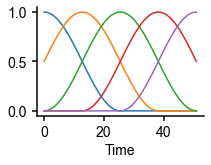

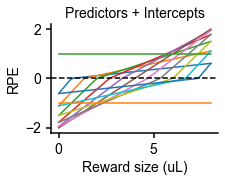

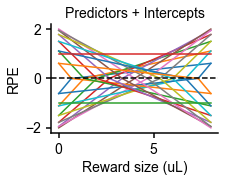

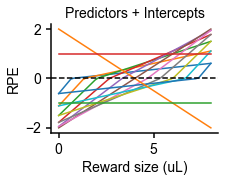

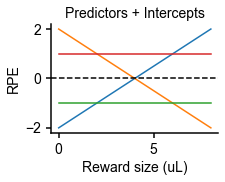

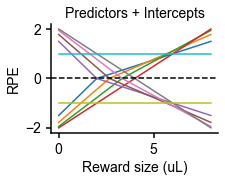

In [8]:
# the targets that we will end up trying to model
n_support = 51
n_bases = 5
n_preds = 11

bases, widths, centers = create_basis(n_support, n_bases)
# support = np.linspace(centers[0], centers[-1], 51)

taus = np.linspace(0.0, 1., n_preds+2)[1:-1]
beta = 1
alpha_pos = taus * beta
alpha_neg = (1. - taus) * beta

# distro = np.arange(0, 10, 2)
distro = np.array([0, 8])
reversals = infer_dist(taus=taus, dist=distro)

support = np.linspace(distro[0], distro[-1], n_support)
iino_data = {'d1': {'neg': 0.5, 'pos': 2},
             'd2': {'neg': 2, 'pos': 0.5}}

response = np.zeros((n_support, n_preds))
d1 = np.zeros((n_support, n_preds))
d2 = np.zeros((n_support, n_preds))

for i_amt, amt in enumerate(support):
    delta = amt - reversals
    isneg = np.array(delta < 0, dtype=np.float32)
    for i_indic, indic in enumerate(isneg):
        if indic:
            response[i_amt, i_indic] = alpha_neg[i_indic] * delta[i_indic]
            d1[i_amt, i_indic] = response[i_amt, i_indic] * iino_data['d1']['neg']
            d2[i_amt, i_indic] = response[i_amt, i_indic] * iino_data['d2']['neg']
        else:
            response[i_amt, i_indic] = alpha_pos[i_indic] * delta[i_indic]
            d1[i_amt, i_indic] = response[i_amt, i_indic] * iino_data['d1']['pos']
            d2[i_amt, i_indic] = response[i_amt, i_indic] * iino_data['d2']['pos']
        
# fit intercept, which requires explicitly giving a -1 and +1 column
response1 = np.hstack((response, -np.ones((n_support, 1)), np.ones((n_support, 1))))
response2 = np.hstack((response, -response, -np.ones((n_support, 1)), np.ones((n_support, 1))))
response3 = np.hstack((response, np.linspace(2, -2, n_support)[:, np.newaxis], 
                      -np.ones((n_support, 1)), np.ones((n_support, 1))))
response4 = np.stack((np.linspace(-2, 2, n_support), np.linspace(2, -2, n_support), 
                      -np.ones(n_support), np.ones(n_support)), axis=1)
central_response = response[:, (n_preds - 1) // 4 : 3 * ((n_preds - 1) // 4)]
response5 = np.hstack((central_response, -central_response, -np.ones((n_support, 1)), np.ones((n_support, 1))))

responses = [response1, response2, response3, response4, response5]

for this_response in responses:
    plt.figure()
    plt.plot(support, this_response)
    plt.axhline(0, c='k', ls='--')
    plt.xlabel('Reward size (uL)')
    plt.ylabel('RPE')
    plt.title('Predictors + Intercepts')
    hide_spines()

In [9]:
n_col = 6
opt_palette = {'Pessimistic': '#BA55D3', 'Optimistic': '#0047AB'}
# colors = [mcol.to_rgb(x) for x in opt_palette.values()]
# cm = LinearSegmentedColormap.from_list('', np.array(colors), 256)

def get_colors(n_colors, cmap, vmin=0, vmax=1):
    """
    For a given colormap, return a list of colors spanning that colormap.
    """
    return cmap(np.linspace(vmin, vmax, n_colors))

rgb = [mcol.to_rgb(x) for x in opt_palette.values()]
uniform = mcol.LinearSegmentedColormap.from_list('', np.array(rgb), 256)
ucols = get_colors(256, cmap=uniform)
cm = mcol.LinearSegmentedColormap.from_list('', ucols[np.array([0, 60, 105, 150, 255]), :], 256)

# x = np.linspace(0.0, 1.0, 100)
# # Get RGB values for colormap.
# rgb = cm(x)[np.newaxis, :, :3]

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect=10, cmap=cm)
plt.axis('off')
plt.savefig('figs/color_gradient.pdf')

# REDRL model schematic

In [10]:
# for i_col in range(n_col // 2):
schematic_taus = np.array([.3, .5, .7])
for tau in schematic_taus:
#     c = cm(i_col / (n_col - 1))
    c = cm(tau)
    print(mcol.to_hex(c))

#8851c8
#6d4fc2
#534dbd


[0.01298701 0.02702703 0.04225352 0.05882353 0.07692308 0.09677419
 0.11864407 0.14285714 0.16981132 0.2        0.23404255 0.27272727
 0.31707317 0.36842105 0.42857143 0.5        0.5862069  0.69230769
 0.82608696 0.17391304 0.30769231 0.4137931  0.5        0.57142857
 0.63157895 0.68292683 0.72727273 0.76595745 0.8        0.83018868
 0.85714286 0.88135593 0.90322581 0.92307692 0.94117647 0.95774648
 0.97297297 0.98701299]
[0.1038961  0.21621622 0.33802817 0.47058824 0.61538462 0.77419355
 0.94915254 1.14285714 1.35849057 1.6        1.87234043 2.18181818
 2.53658537 2.94736842 3.42857143 4.         4.68965517 5.53846154
 6.60869565 1.39130435 2.46153846 3.31034483 4.         4.57142857
 5.05263158 5.46341463 5.81818182 6.12765957 6.4        6.64150943
 6.85714286 7.05084746 7.22580645 7.38461538 7.52941176 7.66197183
 7.78378378 7.8961039 ]


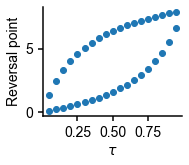

In [11]:
n_preds = 19
taus = np.linspace(.05, .95, n_preds)
redrl_alpha_avg = .015
redrl_beta = 4  # relative boost given to positive (D1) or negative (D2) RPEs
alpha_ps, alpha_ns = get_alphas(taus, redrl_alpha_avg)

alpha_ps_d1 = alpha_ps * redrl_beta
alpha_ns_d2 = alpha_ns * redrl_beta
tau_star_d1 = alpha_ps_d1 / (alpha_ps_d1 + alpha_ns)
tau_star_d2 = alpha_ps / (alpha_ps + alpha_ns_d2)
tau_star = np.concatenate((tau_star_d2, tau_star_d1))
print(tau_star)

distro = np.array([0, 8])
reversals = infer_dist(taus=tau_star, dist=distro)
print(reversals)

plt.figure(figsize=(2.5, 2))
plt.scatter(np.tile(taus, [1, 2]), reversals)
plt.xlabel(r'$\tau$')
plt.ylabel('Reversal point')
hide_spines()

In [12]:
redrl_alpha_avg = .8
iino_data = {'d1': {'neg': .75, 'pos': 3},
             'd2': {'neg': 3, 'pos': .75}}
redrl_beta = iino_data['d1']['pos'] / iino_data['d1']['neg']

alpha_ps, alpha_ns = get_alphas(schematic_taus, redrl_alpha_avg)
alpha_ps_d1 = alpha_ps * redrl_beta
alpha_ns_d2 = alpha_ns * redrl_beta
tau_star_d1 = alpha_ps_d1 / (alpha_ps_d1 + alpha_ns)
tau_star_d2 = alpha_ps / (alpha_ps + alpha_ns_d2)
tau_star = np.concatenate((tau_star_d2, tau_star_d1))
print(tau_star)

distro = np.array([0, 8])
reversals = infer_dist(taus=tau_star, dist=distro)
print(reversals)

[0.09677419 0.2        0.36842105 0.63157895 0.8        0.90322581]
[0.77419355 1.6        2.94736842 5.05263158 6.4        7.22580645]


In [13]:
# schematic_taustar = tau_star[:, np.isin(np.around(taus, 3), np.around(schematic_taus, 3)).nonzero()[0]]
# print(schematic_taustar)

# distro = np.array([0, 8])
# reversals = infer_dist(taus=schematic_taustar.flatten(), dist=distro)
# print(reversals)

In [14]:
n_support = 51
support = np.linspace(distro[0], distro[-1], n_support)
n_preds = len(reversals)

# da = np.zeros((n_support, n_preds))
# d1 = np.zeros((n_support, n_preds))
# d2 = np.zeros((n_support, n_preds))

delta = support[:, np.newaxis] - reversals[np.newaxis, :]
isneg = np.array(delta < 0)
da = delta * np.tile(alpha_ps, (1, 2))
da[isneg] = (delta * np.tile(alpha_ns, (1, 2)))[isneg]

d2 = da * iino_data['d2']['pos']
d2[isneg] = da[isneg] * iino_data['d2']['neg']

d1 = da * iino_data['d1']['pos']
d1[isneg] = da[isneg] * iino_data['d1']['neg']

# d2s are the first three predictors, d1s are the last three
msn = np.concatenate((d2[:, : n_preds // 2], d1[:, n_preds // 2 :]), axis=1)
lss = ['--'] * 3 + ['-'] * 3

meta NOT subset; don't know how to subset; dropped


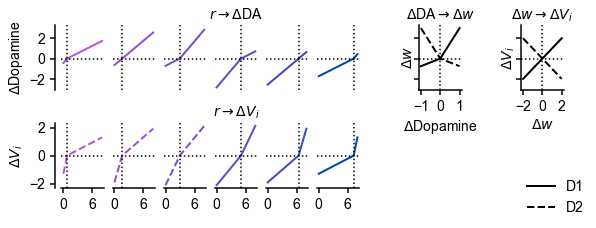

In [15]:
fig, axs = plt.subplots(2, n_col + 4, figsize=(9, 3), gridspec_kw={'hspace': .5})  #, sharey='row')
axs[0, 0].set_ylabel('$\Delta$Dopamine')
axs[1, 0].set_ylabel(r'$\Delta V_i$')

[set_share_axes(axs[:, i_col], sharex=True) for i_col in range(n_col)]
[set_share_axes(axs[i_row, :], sharey=True) for i_row in range(2)]

for i_col in range(n_col):
#     i_pred = 1 + i_col*2
    c = cm(i_col / (n_col - 1))
#     reversal = support[np.argmin(np.abs(response[:, i_pred]))]

#     c = cm(schematic_taus[i_col % len(schematic_taus)])
    
    ax = axs[0, i_col]
    ax.plot(support, da[:, i_col], c=c, lw=2)
    ax.axhline(0, c='k', ls=':')
    ax.axvline(reversals[i_col], c='k', ls=':')
    ax.spines['bottom'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([-2, 0, 2])
    
    if i_col > 0:
        ax.spines['left'].set_color('none')
        ax.set_yticks([])
    else:
        ax.spines['left'].set_position(("axes", -0.15))
    
    if i_col == (n_col) // 2:
#         ax.set_title(r'$\rightarrow$')
        ax.set_title(r'$r \rightarrow \Delta$DA')
        axs[1, i_col].set_title(r'$r \rightarrow \Delta V_i$')
    
    ax = axs[1, i_col]
    ax.plot(support, msn[:, i_col], c=c, ls=lss[i_col], lw=2)
    ax.axhline(0, c='k', ls=':')
    ax.axvline(reversals[i_col], c='k', ls=':')
    ax.set_xticks([0, 6])
    ax.set_yticks([-2, 0, 2])
    
    if i_col > 0:
        ax.spines['left'].set_color('none')
        ax.set_yticks([])
    else:
        ax.spines['left'].set_position(("axes", -0.15))

ax = axs[0, -3]
ax.plot([-1, 0, 1], [-iino_data['d1']['neg'], 0, iino_data['d1']['pos']], c='k', ls='-', lw=2)
ax.plot([-1, 0, 1], [iino_data['d2']['neg'], 0, -iino_data['d2']['pos']], c='k', ls='--', lw=2)
ax.axhline(0, c='k', ls=':')
ax.axvline(0, c='k', ls=':')
ax.set_yticks([-2, 0, 2])
ax.set_xlabel('$\Delta$Dopamine')
ax.set_ylabel(r'$\Delta w$')
ax.set_title(r'$\Delta$DA$\rightarrow \Delta w$')

ax = axs[0, -1]
ax.plot([-2, 0, 2], [-2, 0, 2], c='k', ls='-', lw=2)
ax.plot([-2, 0, 2], [2, 0, -2], c='k', ls='--', lw=2)
ax.axhline(0, c='k', ls=':')
ax.axvline(0, c='k', ls=':')
ax.set_yticks([-2, 0, 2])
ax.set_xlabel('$\Delta w$')
ax.set_ylabel('$\Delta V_i$')
ax.set_title(r'$\Delta w \rightarrow \Delta V_i$')

[ax.remove() for ax in axs[1, -4:]]
axs[0, -2].remove()
axs[0, -4].remove()
ax.legend(['D1', 'D2'], loc=(0, -2))
hide_spines()

plt.savefig('figs/d1_d2_da_expectile_model_schematic_ind.pdf')